In [1]:
import os
os.chdir("/Users/karol/Desktop/Antwerp 1st/ANN/lab/Project/")
from supervising_task.dataloader import validation_15SceneData
from supervising_task.models import Model1
from helper_functions import complex_classifier, get_predicted_images
from evaluation.scorecam import plot_scorecam
from self_supervising_task.models import Rotation2, Preturbation2
import torch
import numpy as np
import pandas as pd
from torchvision import transforms, datasets
from PIL import Image
from torchvision.transforms import ToTensor
from evaluation.RegularizedUnitSpecificImageGeneration import RegularizedClassSpecificImageGeneration
import matplotlib.pyplot as plt
from misc_functions import format_np_output
from torchcam.methods import ScoreCAM
import csv

# Settings summary

In [3]:
# Load rotation model
rotation = torch.load("models/rotation3_classifier.pt").cpu()
rotation.requires_grad_(True)
# # Load preturbation model
preturbation = torch.load("models/preturbation3_classifier.pt").cpu()
preturbation.requires_grad_(True)
# Load supervising model
supervised = torch.load("models/model_final.pt").cpu()

In [3]:
columns = ["Image Size", "Learning Rate", "Optimizer", "Loss", "Batch Size", "Nr of epochs", "Nr of FC layers"]
index = ["Supervising", "Rotation", "Preturbation"]

arr = np.array([["224x224", 0.001, "Adam", "Cross Entropy", 32, 30, 1],
                ["224x224", 0.001, "Adam", "Cross Entropy", 32, 50, 3],
                ["224x224", 0.001, "Adam", "Cross Entropy", 32, 50, 3]])

df = pd.DataFrame(arr, index=index, columns=columns)
df

Image Size Learning Rate Optimizer           Loss Batch Size  \
Supervising     224x224         0.001      Adam  Cross Entropy         32   
Rotation        224x224         0.001      Adam  Cross Entropy         32   
Preturbation    224x224         0.001      Adam  Cross Entropy         32   

             Nr of epochs Nr of FC layers  
Supervising            30               1  
Rotation               50               3  
Preturbation           50               3

# Get all accuracies

In [39]:
# Directory path where the results files are located
directory = 'results/'
# Get the list of CSV files in the directory
csv_files = [file for file in os.listdir(directory)]
# Load second supervising model
accuracies = []
labels = []
for file in csv_files:
    labels.append(file.removesuffix(".csv").removeprefix("accuracy_"))
    with open(directory+file, 'r') as file:
        # Create a CSV reader object
        reader = csv.reader(file)
        # Read the CSV data into a list
        acc_list = list(reader)
        acc = [float(element) for sublist in acc_list for element in sublist]

        accuracies.append(np.max(acc))
pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])

Accuracy
rotation1_classifier      0.518258
model6                    0.726968
model4                    0.916918
model5                    0.705193
model1                    0.928978
preturbation1_classifier  0.619765
model2                    0.918593
model3                    0.913568
rotation2_classifier      0.199665
preturbation3_classifier  0.653936
preturbation1             1.000000
preturbation2_classifier  0.599665
rotation3_classifier      0.629816
rotation1                 0.967839
model_final               0.929983

# Get set of Images for Score-CAM

In [4]:
trainset = datasets.ImageFolder('data/train', transform=transforms.ToTensor())
classes = trainset.classes

# get some correctly predicted pictures
validation_loader = validation_15SceneData()
images_list, labels_list = get_predicted_images(supervised.model, rotation.model, preturbation.model, validation_loader, classes)

# # save images
# for image, label in zip(images_list, labels_list):
#     image = image*255
#     pil_image = Image.fromarray(image.numpy().transpose((1, 2, 0)).astype('uint8'))
#     save_path = 'evaluation/scorecam_images/' + str(label) + '.jpg'  # Specify the save path
#     pil_image.save(save_path)

In [4]:
# load images 
folder_path = 'evaluation/scorecam_images' 
images_list = [] 
labels_list = []
transform = ToTensor()
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    if os.path.isfile(file_path) and any(file_path.endswith(extension) for extension in ['.jpg', '.jpeg', '.png']):
        image = Image.open(file_path)
        tensor_image = transform(image)

        images_list.append(tensor_image)
        labels_list.append(filename.removesuffix(".jpg"))

## Supervised Score-CAM

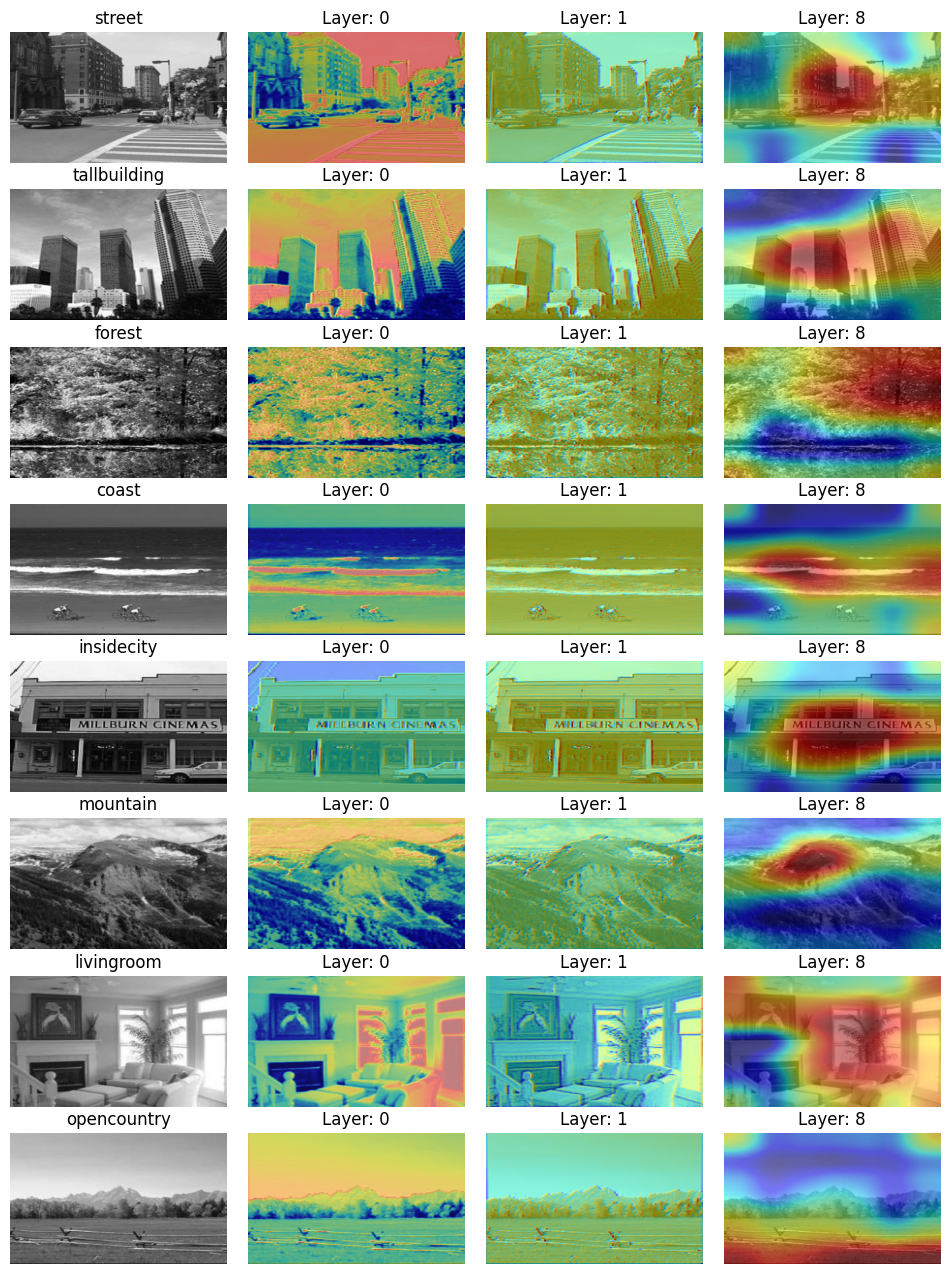

In [5]:
plot_scorecam(supervised, images_list, labels_list)

## Rotation Score-CAM

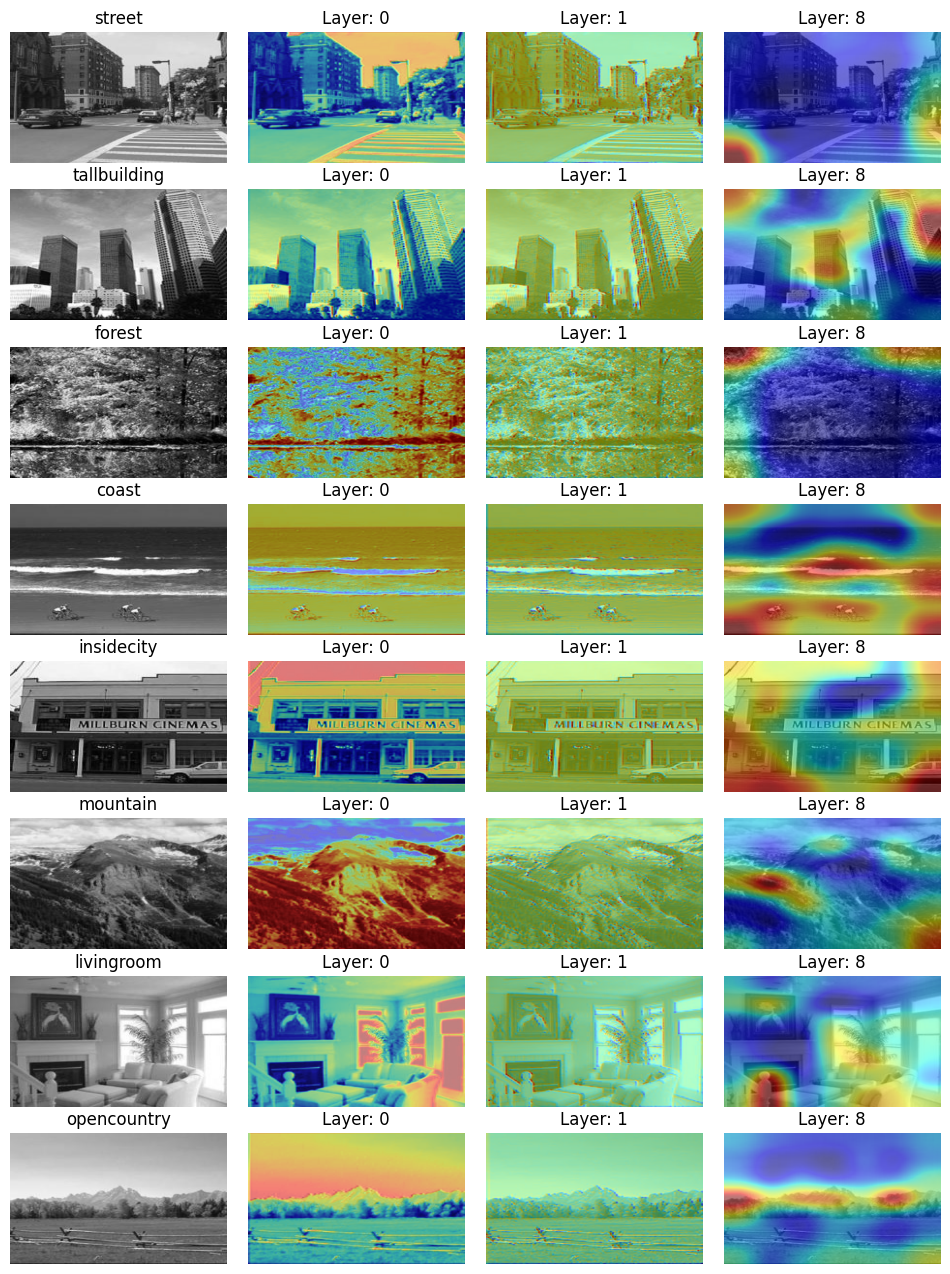

In [6]:
plot_scorecam(rotation, images_list, labels_list)

## Preturbation Score-CAM

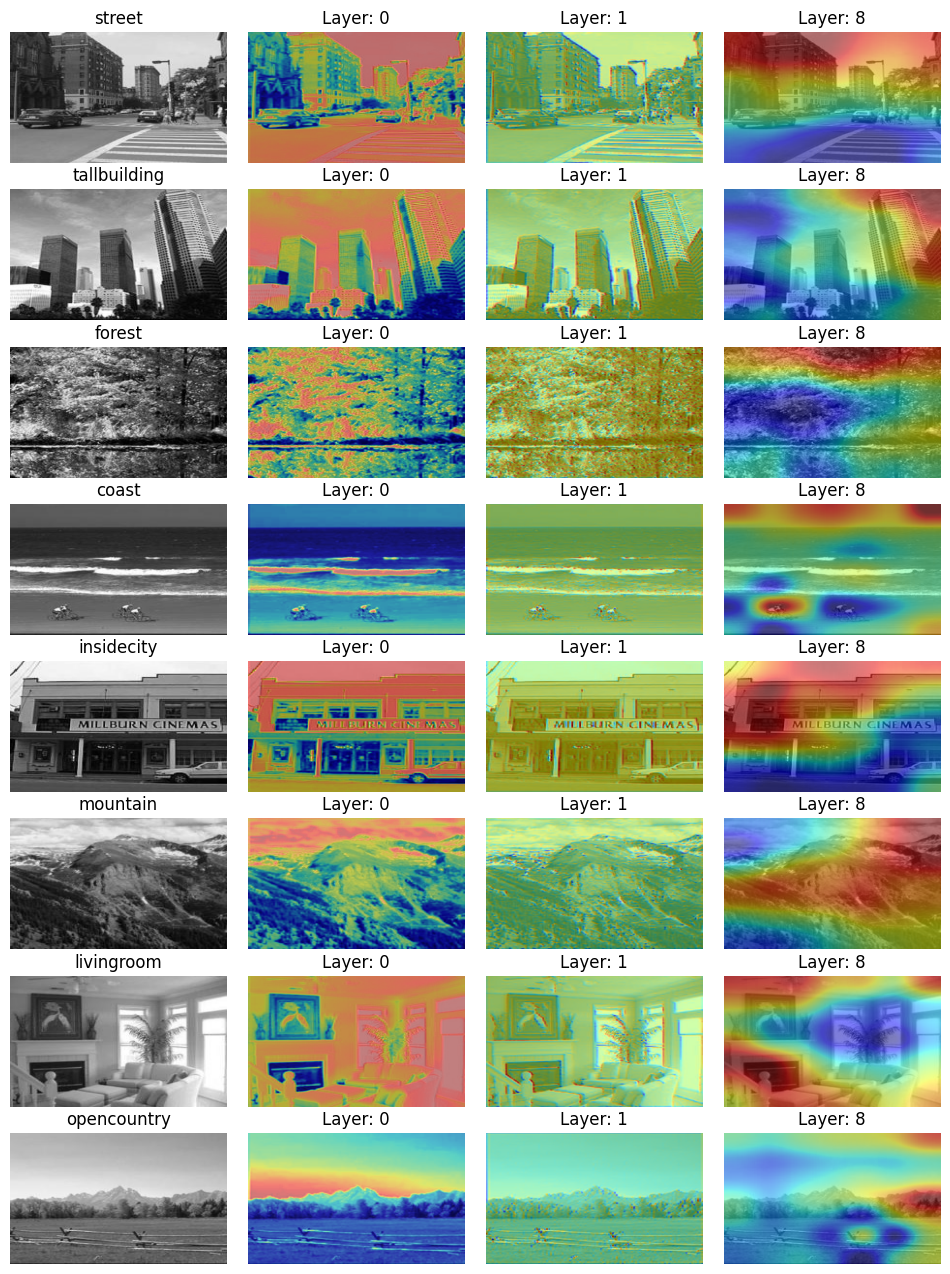

In [7]:
plot_scorecam(preturbation, images_list, labels_list)

# Model Inversion

## Supervised model

In [30]:
trainset = datasets.ImageFolder('data/train', transform=transforms.ToTensor())
classes = trainset.classes
classes[0:5]

['bedroom', 'coast', 'forest', 'highway', 'industrial']

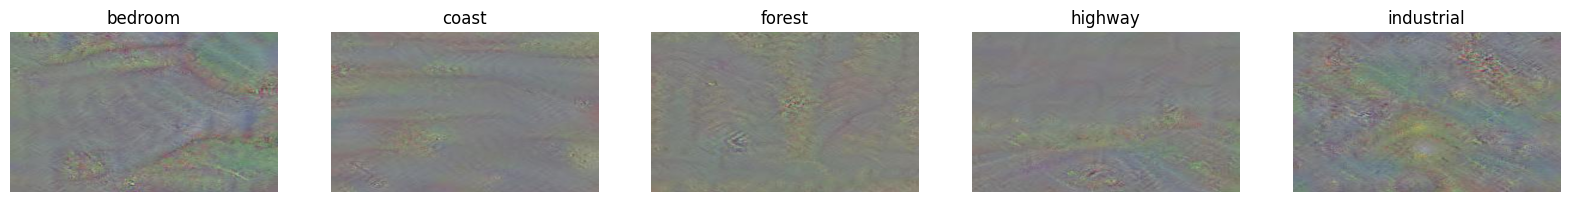

In [31]:
# for cl in np.arange(0,5):
#     target_class = cl 
#     csig = RegularizedClassSpecificImageGeneration(supervised.model, target_class, "supervised")
#     csig.generate(blur_freq=1, blur_rad=2)

fig, axes = plt.subplots(1, 5, figsize=(20, 8))
classes_int = [0,1,2,3,4]
folder_path = 'evaluation/generated/supervised/'
transform = ToTensor()

for cl in classes_int:
    img_path = folder_path + str(cl) + "/img.jpg"
    image = Image.open(img_path)
    axes[cl].imshow(image.resize((500,300)))
    axes[cl].axis("off")
    axes[cl].set_title(classes[cl])

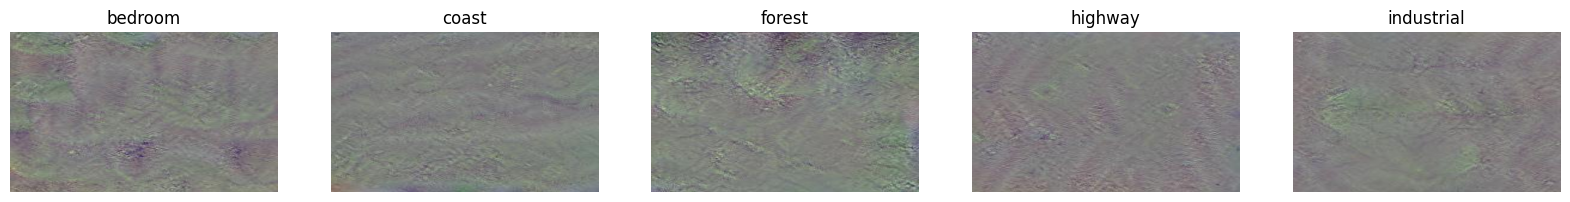

In [32]:
# for cl in np.arange(0,5):
#     target_class = cl
#     csig = RegularizedClassSpecificImageGeneration(rotation, target_class, "rotation")
#     csig.generate(blur_freq=1, blur_rad=2)
    
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
classes_int = [0,1,2,3,4]
folder_path = 'evaluation/generated/rotation/'
transform = ToTensor()

for cl in classes_int:
    img_path = folder_path + str(cl) + "/img.jpg"
    image = Image.open(img_path)
    axes[cl].imshow(image.resize((500,300)))
    axes[cl].axis("off")
    axes[cl].set_title(classes[cl])

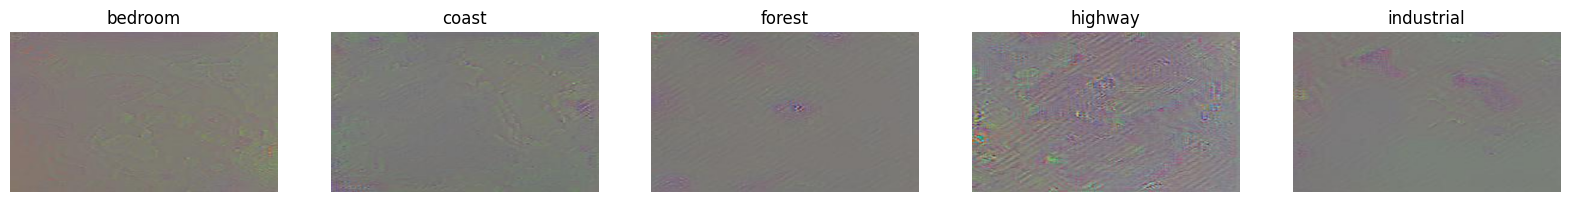

In [34]:
# for cl in np.arange(4,5):
#     target_class = cl
#     csig = RegularizedClassSpecificImageGeneration(preturbation, target_class, "preturbation")
#     csig.generate(blur_freq=1, blur_rad=8, wd=0.001)
    
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
classes_int = [0,1,2,3,4]
folder_path = 'evaluation/generated/preturbation/'
transform = ToTensor()

for cl in classes_int:
    img_path = folder_path + str(cl) + "/img.jpg"
    image = Image.open(img_path)
    axes[cl].imshow(image.resize((500,300)))
    axes[cl].axis("off")
    axes[cl].set_title(classes[cl])

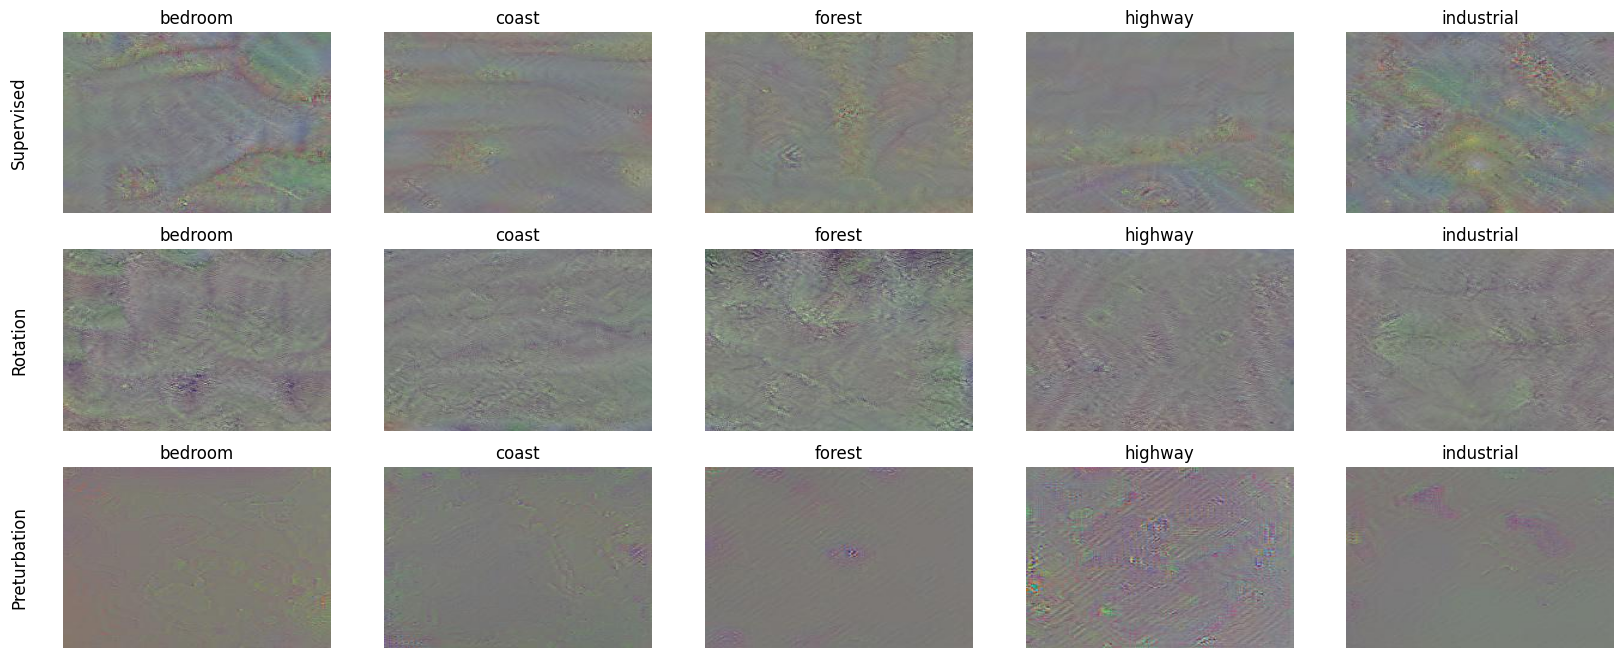

In [49]:
fig, axes = plt.subplots(3, 5, figsize=(20, 8))
classes_int = [0,1,2,3,4]
paths = ['evaluation/generated/supervised/', 'evaluation/generated/rotation/', 'evaluation/generated/preturbation/']
transform = ToTensor()
row_titles = ['Supervised', 'Rotation', 'Preturbation']

for model in range(len(row_titles)):
    for cl in classes_int:
        img_path = paths[model] + str(cl) + "/img.jpg"
        image = Image.open(img_path)
        axes[model,cl].imshow(image, aspect='auto')
        axes[model,cl].axis("off")
        axes[model,cl].set_title(classes[cl])
    row_title = axes[model,0].text(-0.2, 0.5, row_titles[model], transform=axes[model,0].transAxes, fontsize=12, va='center')
    row_title.set_rotation(90)